In [52]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm

import corner
import copy

import multiprocessing as mp

from tqdm import tqdm

from functools import partial

# Setup

In [53]:
class HMC():
    """
    Hamiltonian Monte Carlo sampler
    https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
    """
    
    def __init__(self, logp, dlogp, dt, L, M, n_args, prop='leapfrog'):
        """
        Arguments:
            logp: 
                Function which accepts two inputs (args, data) and returns log
                probability of the objective model
                
            dlogp:
                Function which which accepts two inputs (args, data) and returns the
                gradient of the log probability w.r.t. the parameters as a np array
                
            dt: Time step
            
            L: Number of leapfrog iterations to calculate
            
            M: covariance of momentum sampling multivariate normal
            
            n_args: number of parameters to sample
        """
        self.logp = logp
        self.dlogp = dlogp
        self.dt = dt
        self.L = L
        self.M = M
        self.n_args = n_args
        
        if prop=='leapfrog':
            self.proposal = self.prop_lf
        elif prop=='yoshida':
            self.proposal = self.prop_yo
        else:
            raise
    
    def U(self, x, data):
        return -self.logp(x,data)
    
    def dU(self, x, data):
        return -self.dlogp(x,data)
    def K(self, v):
        return -mvnorm.logpdf(v, mean=np.zeros(self.n_args), cov=self.M)
    
    def prop_lf(self, x, v, data):
        # Leapfrog
        # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
        x, v = copy.deepcopy((x,v))
        
        for _ in range(self.L):
            v -= (self.dt/2)*self.dU(x, data)
            x += self.dt*np.dot(np.linalg.inv(self.M), v)
            v -= (self.dt/2)*self.dU(x, data)
        
        return x, v
    
    def prop_yo(self, x, v, data):
        # 4th order Yoshida integrator
        # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
        x, v = copy.deepcopy((x,v))
        
        crt2 = (2**(1./3))
        w0 = -crt2/(2-crt2)
        w1 = 1/(2-crt2)
        c1=c4=w1/2
        c2=c3=(w0+w1)/2
        d1=d3=w1
        d2=w0
        
        for _ in range(self.L):
            x += c1*v*self.dt
            v += d1*self.dU(x, data)*self.dt
            x += c2*v*self.dt
            v += d2*self.dU(x, data)*self.dt
            x += c3*v*self.dt
            v += d3*self.dU(x, data)*self.dt
            x += c4*v*self.dt
        
        return x, v
    
    
    def sample(self, N_samp, data, init_x=None, verbose=False):
        """Samples one HMC chain for N_samp samples."""
        
        if init_x is None:
            x = 2*np.random.rand(self.n_args)-0.5
        else:
            x = init_x
            
        xs = np.zeros(shape=(N_samp, self.n_args))
        xs[0] = x
        
        i_s = range(1,N_samp)
        if verbose: # Print progress bar
            i_s = tqdm(i_s)
        
        for i in i_s:
            v = mvnorm.rvs(mean=np.zeros(self.n_args), cov=self.M)

            xnew, vnew = self.proposal(x, v, data)

            alpha = np.exp(self.U(x, data) +  self.K(v)
                           - self.U(xnew, data) - self.K(vnew))

            if np.random.rand() <= min(1, alpha):
                xs[i] = xnew
                x = xnew
            else:
                xs[i] = xs[i-1]
                
        return xs
    
    def _pool_helper(self, N_samp, data, init_x, verbose, seed):
        np.random.seed(seed)
        return self.sample(N_samp, data, init_x, verbose)
    
    def sample_pool(self, N_samp, data, N_chains, init_x=None, verbose=False):
        """Samples N_chains HMC chains in parallel, each for N_samp samples"""
        
        f = partial(self._pool_helper, N_samp, data, init_x, verbose)
        
        with mp.Pool(N_chains, initargs=(N_samp, data, init_x)) as pool:
            out = np.array(pool.map(f, 
                                    np.random.randint(0, 1e5, N_chains),
                                    ))
            
        return out

# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [34]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)

print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: -0.0005537290004161932, sig_hat: 1.0030560184022936


In [35]:
# Define Model

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    if args[1] <= 0:
        return 0
    return np.sum(norm.logpdf(data, *args))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu, sig = args
    dmu = np.sum((data - mu)/(sig**2))
    dsig = np.sum((mu**2 - sig**2 - 2*mu*data + data**2)/(sig**3))
    return np.array([dmu, dsig])

In [36]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2)

In [37]:
# Run sampling
xs = sampler.sample(int(1e4), data, init_x=[0.1,0.5], verbose=True)

100%|██████████| 9999/9999 [00:27<00:00, 360.95it/s]


In [38]:
# Burn
xs = xs[100:,:]

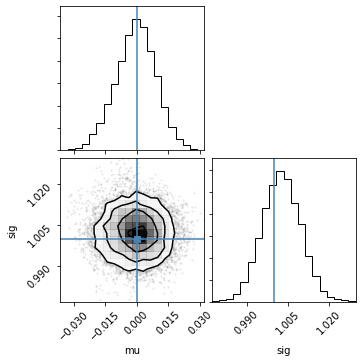

In [39]:
# Corner plot
f = corner.corner(xs.reshape(-1,2), truths=truth, labels=['mu', 'sig'])

(0, 9900)

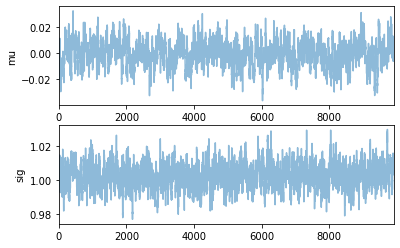

In [42]:
# Trace

f, axs = plt.subplots(2,1)

axs[0].plot(xs[:,0], label='mu', alpha=0.5)
axs[0].set_ylabel('mu')
axs[0].set_xlim(0,xs.shape[0])

axs[1].plot(xs[:,1], label='sig', alpha=0.5)
axs[1].set_ylabel('sig')
axs[1].set_xlim(0,xs.shape[0])

# Multivariate Normal + LF

In [44]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [5.97881599 2.89785195 6.30528672 5.0910741  8.43868262], sig_*: [[3.23751692 0.         0.         0.         0.        ]
 [0.         0.55427108 0.         0.         0.        ]
 [0.         0.         4.16304037 0.         0.        ]
 [0.         0.         0.         4.78123792 0.        ]
 [0.         0.         0.         0.         0.11412931]]
mu_hat: 5.741895771196685, sig_hat: [[ 4.13548814  4.13102122  3.44372846 ...  4.15834119  3.3087771
   3.20559965]
 [ 4.13102122  7.90793988  8.48689284 ...  2.89066008  6.34719404
   3.7890078 ]
 [ 3.44372846  8.48689284 12.55280142 ... -0.3656479   6.3917822
   0.35613511]
 ...
 [ 4.15834119  2.89066008 -0.3656479  ...  6.50729217  2.48044023
   5.65798604]
 [ 3.3087771   6.34719404  6.3917822  ...  2.48044023  5.21023474
   3.33012118]
 [ 3.20559965  3.7890078   0.35613511 ...  5.65798604  3.33012118
   6.24521628]]


In [45]:
# Define Model
n_args = 2*ndims 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    if (sigs <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mus, np.diag(sigs)))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    dmu = np.sum((data - mus)/(sigs**2), axis=0)
    dsig = np.sum((mus**2 - sigs - 2*mus*data + data**2)/(2*sigs**2), axis=0)
    return np.concatenate([dmu, dsig])

In [46]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2*ndims), n_args=2*ndims)

In [47]:
# Run sampling
N_chains = mp.cpu_count()-1
xs = sampler.sample_pool(int(1e4), data, N_chains, 
                         init_x = np.concatenate([mu_tru, sig_tru]), verbose=True)

100%|██████████| 9999/9999 [08:32<00:00, 19.51it/s]


In [48]:
# Burn
xs = xs[:,100:,:]

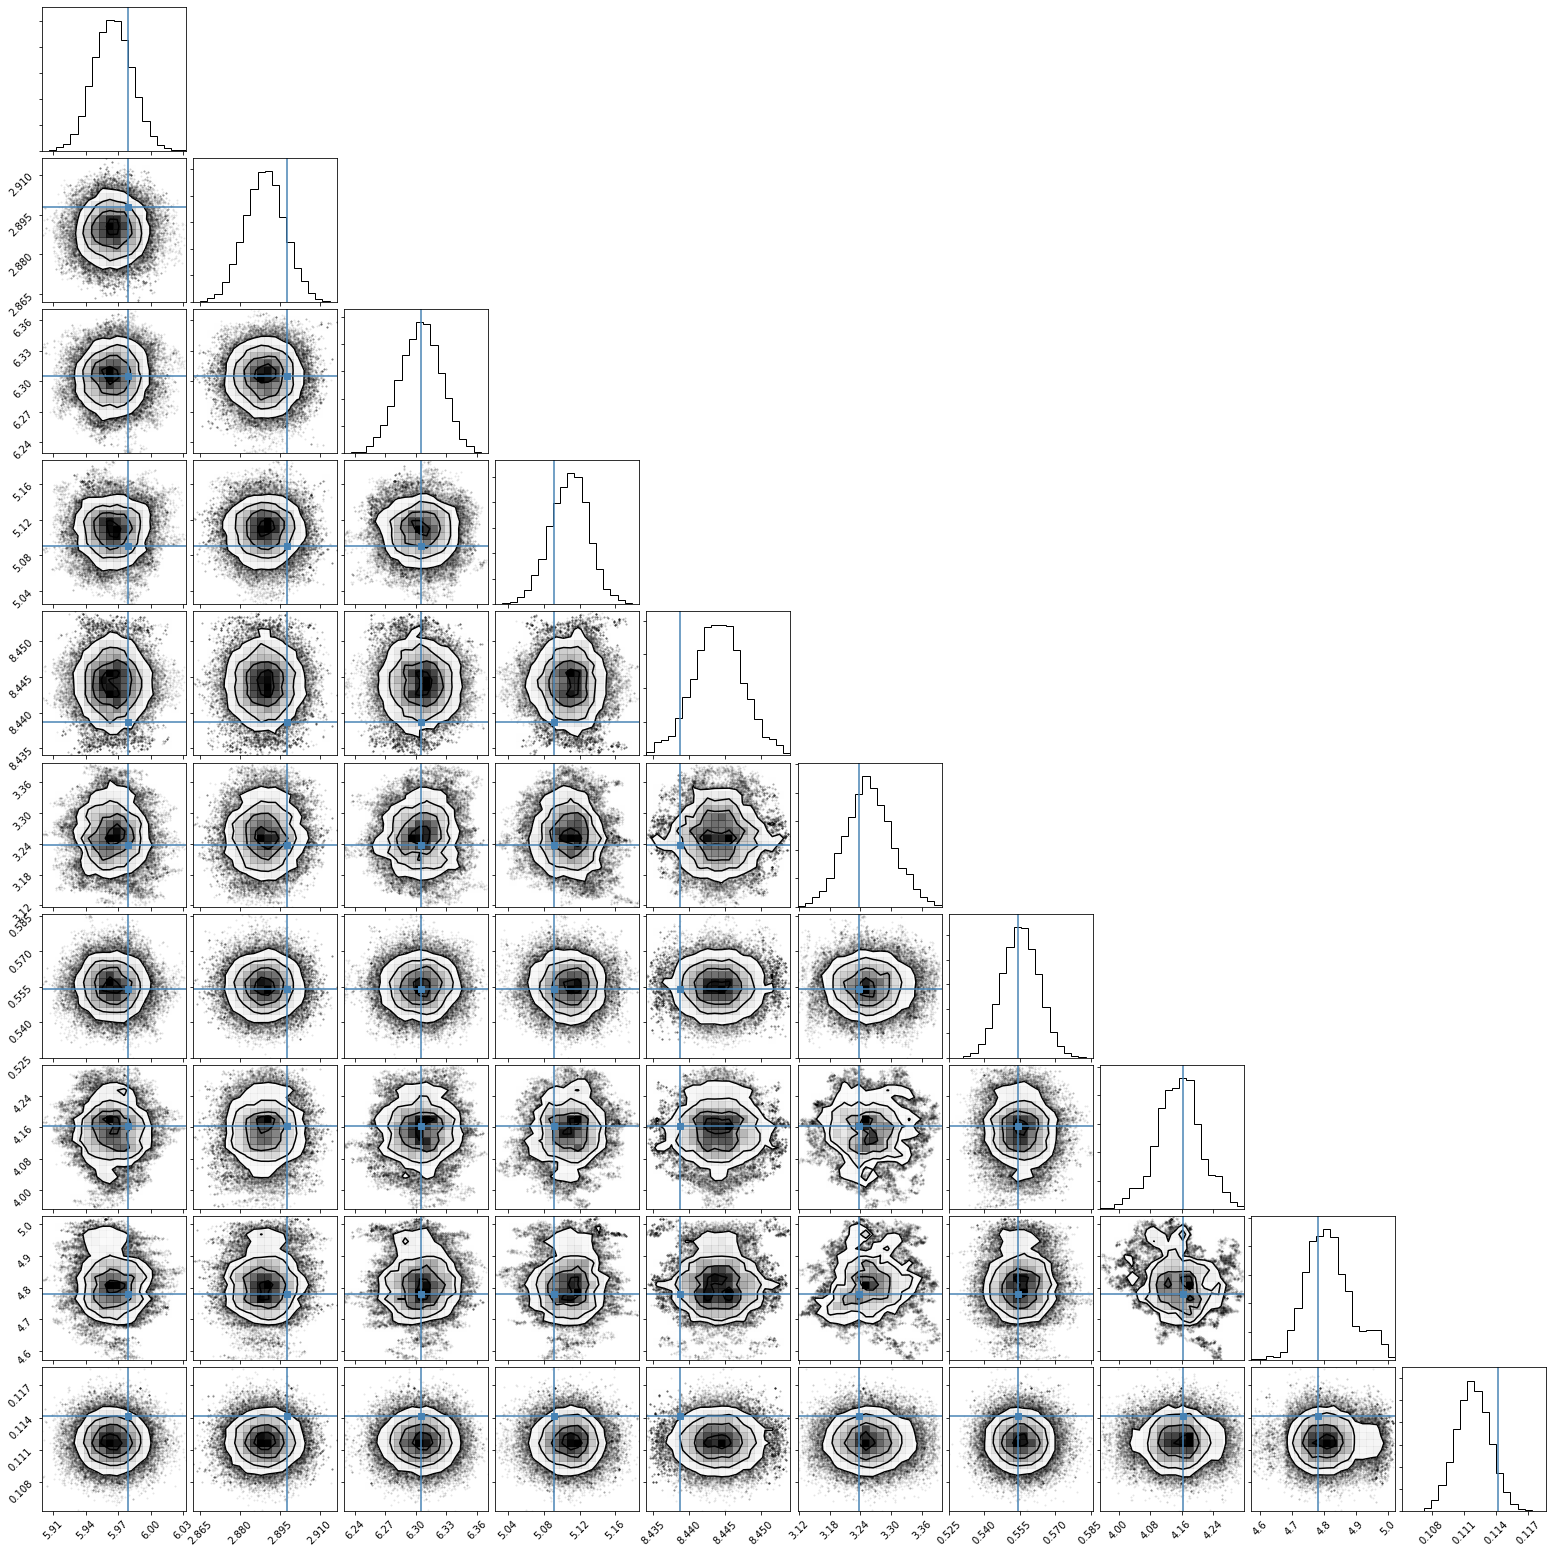

In [49]:
# Corner plot
f = corner.corner(xs.reshape(-1,n_args), truths=np.concatenate([mu_tru, sig_tru]))#, labels=['mu', 'sig'])

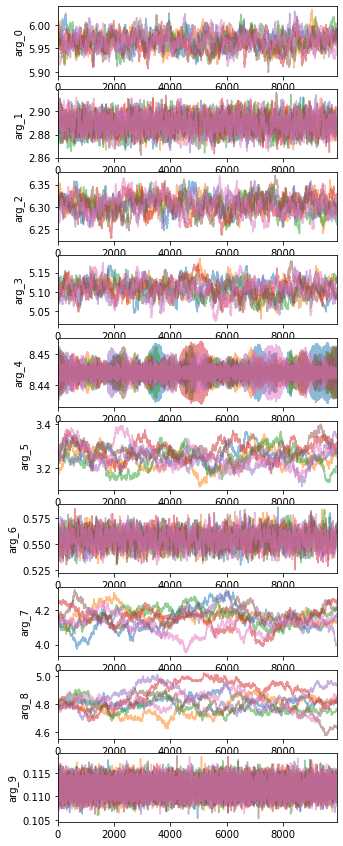

In [50]:
# Trace

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,:,j], alpha=0.5)
    axs[j].set_ylabel(f'arg_{j}')
    axs[j].set_xlim(0,xs.shape[1])


# Multivariate Normal + Yoshida

In [54]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [0.96636179 3.61957762 8.90778693 3.09576045 4.39178368], sig_*: [[4.31527547 0.         0.         0.         0.        ]
 [0.         1.51064499 0.         0.         0.        ]
 [0.         0.         1.20972361 0.         0.        ]
 [0.         0.         0.         1.80209741 0.        ]
 [0.         0.         0.         0.         4.6936535 ]]
mu_hat: 4.199944951187414, sig_hat: [[ 6.90638461  9.21055709  8.3289612  ...  1.08726832  8.56416635
   5.56573956]
 [ 9.21055709 12.98914307 10.03588797 ...  1.21589714 11.40408687
   7.9671639 ]
 [ 8.3289612  10.03588797 13.48047107 ...  4.82325008 12.41765523
   7.92023153]
 ...
 [ 1.08726832  1.21589714  4.82325008 ...  6.02565408  4.67894748
   4.06227475]
 [ 8.56416635 11.40408687 12.41765523 ...  4.67894748 13.26367357
   9.40537692]
 [ 5.56573956  7.9671639   7.92023153 ...  4.06227475  9.40537692
   7.32751698]]


In [55]:
# Define Model
n_args = 2*ndims 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    if (sigs <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mus, np.diag(sigs)))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    dmu = np.sum((data - mus)/(sigs**2), axis=0)
    dsig = np.sum((mus**2 - sigs - 2*mus*data + data**2)/(2*sigs**2), axis=0)
    return np.concatenate([dmu, dsig])

In [56]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2*ndims), 
              n_args=2*ndims, prop='yoshida')

In [57]:
# Run sampling
N_chains = mp.cpu_count()-1
xs = sampler.sample_pool(int(1e4), data, N_chains, 
                         init_x = np.concatenate([mu_tru, sig_tru]), verbose=True)

100%|██████████| 9999/9999 [11:46<00:00, 14.15it/s]


In [58]:
# Burn
xs = xs[:,100:,:]

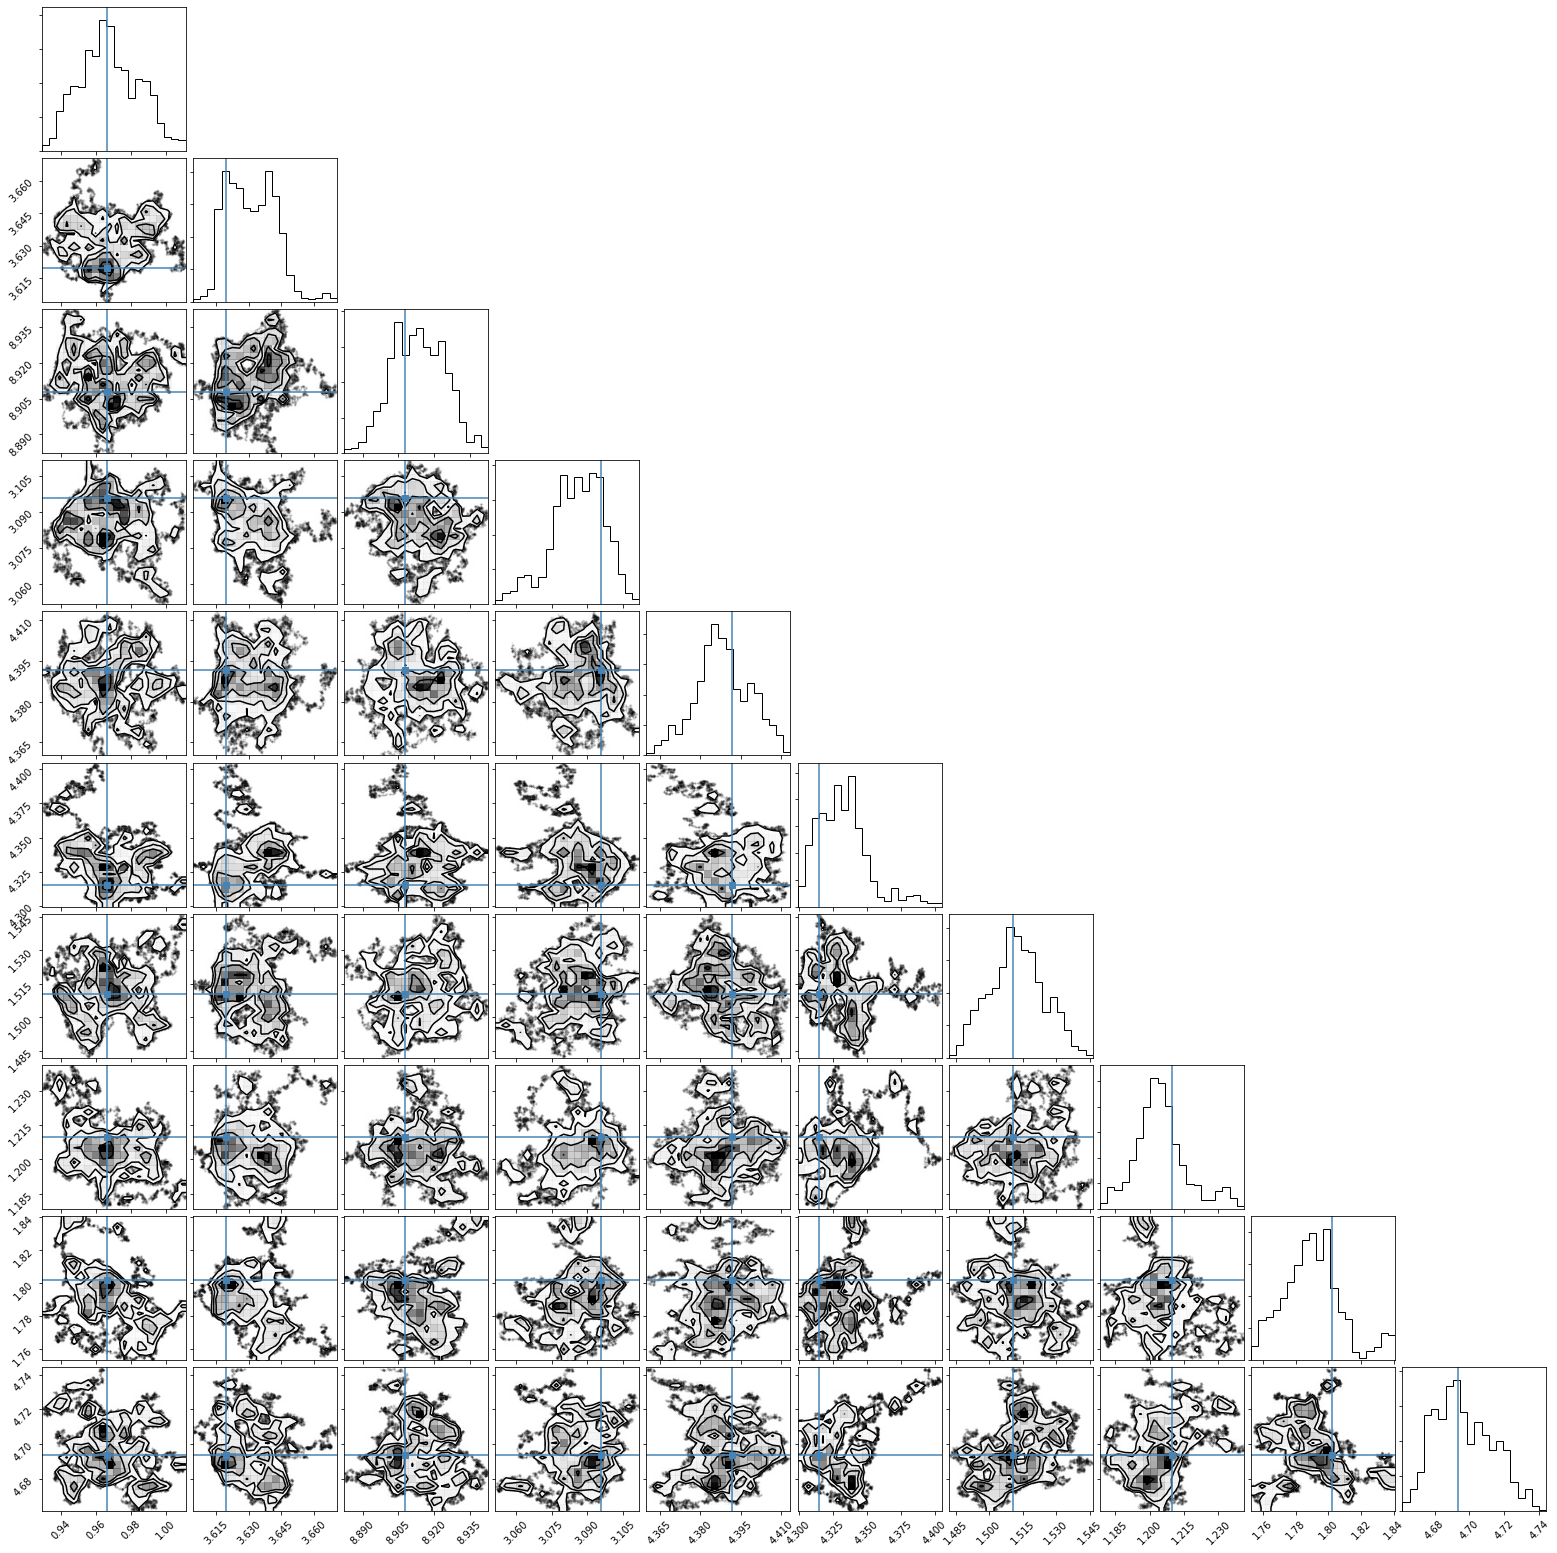

In [59]:
# Corner plot
f = corner.corner(xs.reshape(-1,n_args), truths=np.concatenate([mu_tru, sig_tru]))#, labels=['mu', 'sig'])

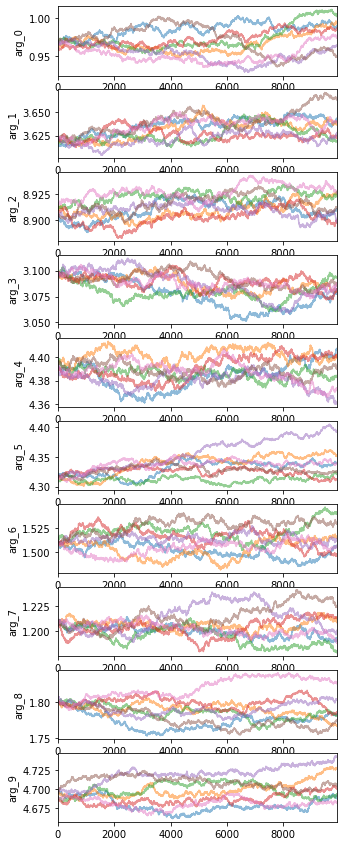

In [60]:
# Trace

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,:,j], alpha=0.5)
    axs[j].set_ylabel(f'arg_{j}')
    axs[j].set_xlim(0,xs.shape[1])


# Scratch